# Train model : Support Vector Regressor

# Purpose
Train a machine learning model

# Methodology

# Setup

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 462 ('figure.figsize   : 5, 3   ## figure size in inches')
Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 463 ('figure.dpi       : 100        ## figure dots per inch')


In [2]:
import os
import matplotlib.pyplot as plt
import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option("display.max_columns", None)
import sympy as sp

import pandas as pd
import numpy as np

import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn.metrics import r2_score, mean_absolute_error
from scipy.integrate import solve_ivp
import seaborn as sns

from copy import deepcopy
import sys
sys.path.append('../../')
from src.notebook_to_latex import Equation, equation_dict
#from src import equations,symbols
import reports.paper_writing
from src.df_to_latex import LateXTable
import src.data.load as load
from src.data.transform import transform, extend
from src.visualization.visualize import plotable_dataframe
from src.visualization.polynom import model_to_string, model_to_sympy

import plotly.express as px 
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.model_selection import GridSearchCV

import xgboost
from sklearn.svm import SVR
import mlflow
from src import mlflow_utils
from src.data.train_test_validate import get_train_test, get_cross_validation

## Examples:


In [3]:
# enable autologging
# mlflow.sklearn.autolog()

## Parameters

In [4]:
run_params = {
    'data_path' : '../../data/processed/data_extended.csv',
    'n_splits' :6,
    'n_repeats' : 1,
    'rolling_cv' : True,
    'rolling_test': True,
    'test_size' : 0.2,
    'experiment' : 'rolling_fit',
    'model_name' : 'polynomial',
    'run_name' :  'testing',
}

In [6]:
data = pd.read_csv(run_params['data_path'], index_col=0)

In [7]:
data.head()

,Power,V,HDG,Hs,Tz,D_wave,U_wind,V_wind,T,trim,u_wind,v_wind,wave_direction
0,4096.859211,23.359333,225.120423,0.336355,4.113880,58.287071,-0.251960,0.598855,10.225,-0.05,-0.246556,-0.601100,-166.833351
1,4062.904838,23.351923,225.121609,0.334025,4.107303,61.219389,-0.205543,0.537524,10.225,-0.05,-0.235861,-0.524928,-163.902220
2,4105.640943,23.304333,213.803859,0.331768,4.100033,64.378446,-0.167395,0.480271,10.225,-0.05,-0.128103,-0.492211,-149.425413
3,4156.401020,23.293167,225.124531,0.328743,4.084423,69.095584,-0.153352,0.410798,10.225,-0.05,-0.182908,-0.398517,-156.028946
4,4147.498244,23.287000,225.125682,0.326883,4.072262,73.970302,-0.125637,0.360612,10.225,-0.05,-0.166907,-0.343465,-151.155380


## train/test-split

In [8]:
X_train, X_test, y_train, y_test = get_train_test(data=data, rolling=run_params['rolling_test'], label='Power', test_size=run_params['test_size'])

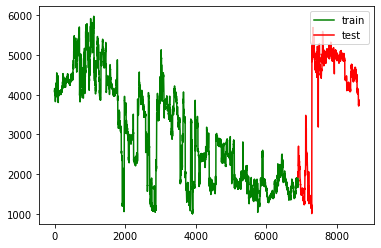

In [9]:
fig,ax=plt.subplots()
y_train.plot(style='g-', ax=ax, label='train')
y_test.plot(style='r-', ax=ax, label='test')
ax.legend(loc='upper right');

## cross-validation on a rolling basis

In [10]:
cv = get_cross_validation(n_splits=run_params['n_splits'], 
                          n_repeats=run_params['n_repeats'], rolling=run_params['rolling_cv'])

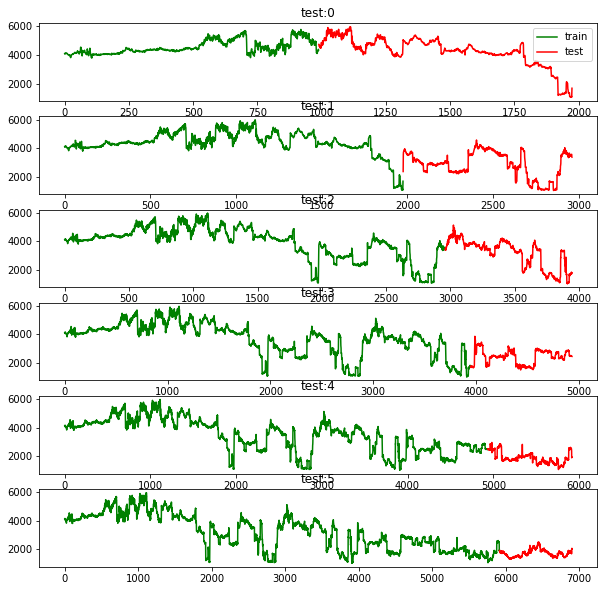

In [11]:
fig,axes=plt.subplots(nrows=run_params['n_splits'])
fig.set_size_inches(10,10)

scores=[]
for i,(train_index, test_index) in enumerate(cv.split(X_train)):
    ax = axes[i]
    X_train_ = X_train.iloc[train_index]
    y_train_ = y_train.iloc[train_index]
    X_test_ = X_train.iloc[test_index]
    y_test_ = y_train.iloc[test_index]
    
    y_train_.plot(style='g-', ax=ax, label='train')
    y_test_.plot(style='r-', ax=ax, label='test')
    ax.set_title(f'test:{i}')
    
axes[0].legend(loc='upper right');


## Define model

In [12]:
model = SVR()

In [15]:
from sklearn.feature_selection import chi2

# define the grid
grid = dict()
#grid['select_k_best__k'] = [i for i in range(1,15)]
#grid['polynomial_features__degree'] = [i for i in range(1, 3)]

grid = [
  {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    
  }
]

# define the grid search
search = GridSearchCV(estimator=model, 
                      param_grid=grid, 
                      scoring='neg_mean_absolute_error', 
                      n_jobs=-1, cv=cv)

In [16]:
#with mlflow.start_run() as run:
#    search_result = search.fit(X_train, y_train)

search_result = search.fit(X_train, y_train)

In [17]:
best_model=search_result.best_estimator_

2021-06-14 13:47:42,755 - Model saved to: E:\dev\ship_power_prediction\notebooks\pipeline\../..\models\polynomial.pickle
2021-06-14 13:47:43,094 - Precision-recall curve saved to: plots/plot_test_polynomial.png


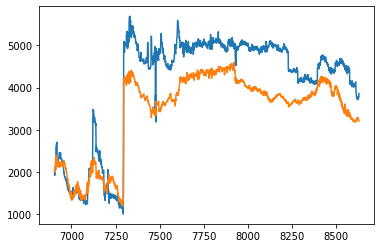

In [18]:
run = mlflow_utils.log_mlflow(run_params=run_params, model=best_model, X_test=X_test, y_test=y_test)